# Spanish News Article's origin site determination
## Using a Bert pre-trained multi-language model enhanced by Transfer Learning
## Trained on Google Colab

In [0]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sn
from matplotlib.colors import LogNorm
from operator import itemgetter
import pickle

In [0]:
#Configuration parameters
maxlen=500 #Maximum length of texts from the beggining of articles

In [3]:
!pip install pytorch-pretrained-bert==0.4.0

In [4]:
import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertForSequenceClassification, BertAdam
from tqdm import tqdm_notebook,trange

Using TensorFlow backend.


Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [5]:
#Mounting Google drive (Requires key)
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [23]:
torch.cuda.get_device_name(0) 

'Tesla K80'

# Read data

In [6]:
#Introduce path to CSV with article's text as created by Preprocess Notebook
dframe=pd.read_csv("PATH_TO_CSV")
dframe.head(5)

,Unnamed: 0,pais,domain,site,tipo,autor,texto
0,190182,US,1868,el-nacional.com,news,Juan Carlos D Az,Un país sin futuro ni oportunidades Tweet: Jua...
1,323503,ES,2957,telecinco.es,news,NaN,"José Manuel López dice que la ""hoja de ruta"" e..."
2,333942,ES,1487,abc.es,news,(lavozdigital),TURISMO Los turistas se dan de bruces con la r...
3,148948,ES,4291,eldiario.es,news,esglobal,Un hombre ha resultado muerto al ser arrastrad...
4,165938,ES,6093,coches.net,news,NaN,La pregunta no puede contener URLs Tu nombre T...


In [0]:
dframe=dframe[['site','texto']]
dframe.dropna(inplace=True)

In [9]:
dframe.site.value_counts()

eleconomista.es       21873
coches.net            11508
europapress.es        11031
eldiario.es           10384
telecinco.es          10206
abc.es                 9749
milenio.com            8946
yahoo.com              7183
meneame.net            6651
elcomercio.pe          5737
biobiochile.cl         5555
lanacion.com.ar        5367
elpais.com             5262
clarin.com             5257
boe.es                 4651
el-nacional.com        4515
debate.com.mx          4268
elmundo.es             4249
mundodeportivo.com     4179
Name: site, dtype: int64

In [10]:
len(dframe)

146571

# Preprocess data

In [0]:

dframe['texto']=dframe.texto.apply(lambda x: str.lower(x))
table = str.maketrans({key: None for key in string.punctuation})
dframe['texto']=dframe.texto.apply(lambda x: x.translate(table))

In [0]:
dframe['words']=dframe.texto.apply(lambda x: x.split())

In [0]:
dframe['len']=dframe['words'].apply(lambda x: len(x))

In [0]:
dframe=dframe[dframe.len>5]

In [15]:
print ('Maximum sequence length:', max([len(s) for s in dframe.words]))

Maximum sequence length: 19891


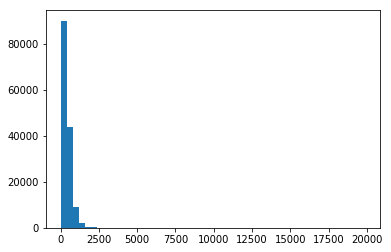

In [16]:
plt.hist([len(s) for s in dframe.words], bins=50)
plt.show()

In [17]:
words= [item for sublist in list(dframe.words) for item in sublist]
words = list(set(words))
words.append("ENDPAD")
n_words=len(words)
n_words

548242

In [18]:
tags = list(set(dframe["site"].values))
n_tags = len(tags)
n_tags

19

In [19]:
tags

['lanacion.com.ar',
 'elmundo.es',
 'milenio.com',
 'debate.com.mx',
 'elcomercio.pe',
 'eldiario.es',
 'telecinco.es',
 'europapress.es',
 'mundodeportivo.com',
 'clarin.com',
 'eleconomista.es',
 'biobiochile.cl',
 'elpais.com',
 'abc.es',
 'coches.net',
 'meneame.net',
 'yahoo.com',
 'el-nacional.com',
 'boe.es']

In [0]:
tag2idx = {t: i for i, t in enumerate(tags)}

In [0]:
#Save assignation of sites to tags for posterior use 
#Introduce path where to save
pickle_out = open('OUTPUT_PATH/tag_dict.pkl',"wb")
pickle.dump(tag2idx, pickle_out)
pickle_out.close()

## Text Tokenization using Bert model obtained from https://github.com/google-research/bert/blob/master/multilingual.md

In [0]:
#Introduce path to model file
tokenizer = BertTokenizer.from_pretrained('PATH_TO_MODEL', do_lower_case=True)

In [25]:
tokens={}
for w in tqdm_notebook(words):
    token=tokenizer.tokenize(w)
    tokens[w]=token   
        

In [0]:
def tokenize_sentence(ls,tokens):
    t=[]
    for l in ls:
        t=t+tokens[l]
    return t

In [0]:
dframe['tokens']=dframe.words.apply(lambda x: tokenize_sentence(x,tokens))

In [0]:
dframe['input']=dframe.tokens.apply(lambda x: tokenizer.convert_tokens_to_ids(x))
dframe['label']=dframe.site.apply(lambda x:tag2idx[x] )

In [0]:
inputs=pad_sequences(dframe.input,maxlen=maxlen, dtype="long", truncating="post", padding="post")

In [0]:
#Split data into train, validation and test sets
tr_inputs, aux_inputs, tr_tags, aux_tags= train_test_split(inputs,list(dframe.label), random_state=1977, test_size=0.05, stratify=dframe.label)
val_inputs, test_inputs, val_tags, test_tags = train_test_split(aux_inputs,aux_tags, random_state=1977, test_size=0.5, stratify=aux_tags)

# Prepare model for Transfer learning

In [0]:
#Tensor inputs
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
test_inputs = torch.tensor(test_inputs)

tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
test_tags = torch.tensor(test_tags)


In [0]:
bs = 8
train_data = TensorDataset(tr_inputs, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [0]:
# Load model
model= BertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased', num_labels=n_tags)

In [35]:
model.to('cuda')

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): BertInterm

In [0]:
#Prepare model for parameter tunning
epochs = 10
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
num_train_optimization_steps= int(len(tr_inputs) / bs) * epochs
optimizer = BertAdam(optimizer_grouped_parameters, lr=3e-6,warmup=0.1,t_total=num_train_optimization_steps)

# train model

In [0]:
def flat_accuracy(preds, labels):
    return np.sum(np.argmax(preds, axis=1) == labels) / len(labels)

In [0]:

max_grad_norm = 1.0

for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    epoch_sample=list(enumerate(train_dataloader))
    train_size=int(len(epoch_sample)/10)
    epoch_sample=epoch_sample[0:train_size]
    for step, batch in epoch_sample:
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_labels = batch
        # forward pass
        loss = model(b_input_ids, token_type_ids=None,labels=b_labels)
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model.zero_grad()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_labels = batch
        
        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in logits])
        true_labels.append(label_ids)
        #print("prediction: "+str(np.argmax(logits, axis=1)))
        #print("label*****: "+str(label_ids))
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 2.8381378264967987



Epoch:  10%|█         | 1/10 [1:01:08<9:10:13, 3668.12s/it]

Validation loss: 2.687086489523342
Validation Accuracy: 0.22298034934497818
Train loss: 2.607569458502493



Epoch:  20%|██        | 2/10 [2:02:18<8:09:11, 3668.89s/it]

Validation loss: 2.468813300653316
Validation Accuracy: 0.24399563318777293


# Validate Model

In [0]:
test_data = TensorDataset(test_inputs, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=bs)

In [0]:
test_loss, test_accuracy = 0, 0
nb_test_steps=0
predictions , true_labels = [], []
for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_labels = batch
        
        with torch.no_grad():
            tmp_test_loss = model(b_input_ids, token_type_ids=None, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in logits])
        #print("prediction: "+str(np.argmax(logits, axis=1)))
        #print("label*****: "+str(label_ids))
        tmp_test_accuracy = flat_accuracy(logits, label_ids)
        
        test_loss += tmp_test_loss.mean().item()
        test_accuracy += tmp_test_accuracy
        
        nb_test_steps += 1
test_loss = test_loss/nb_test_steps
print("Test loss: {}".format(test_loss))
print("Test Accuracy: {}".format(test_accuracy/nb_test_steps))

# Save model parameters for posterior use

In [0]:
state_dict_with_prefix={}
for key,value in model.named_parameters():
    state_dict_with_prefix[key] = value

In [0]:
# Introduce path where to save model
pickle_out = open('OUTPUT_PATH/model.pkl',"wb")
pickle.dump(state_dict_with_prefix, pickle_out)
pickle_out.close()

------